Start complete streamflow-precipitation elasticity analysis
 Data Loading and Preprocessing
 Original data shape: (4346, 198)
 Shape after filtering: (4042, 198)
Highly correlated feature de-duplication: 77 features removed, 119 features remaining
Low variance feature removal: 3 features removed, 116 features remaining
 Training set: (3233, 116), Test set: (809, 116)

 Target Variable Distribution Analysis


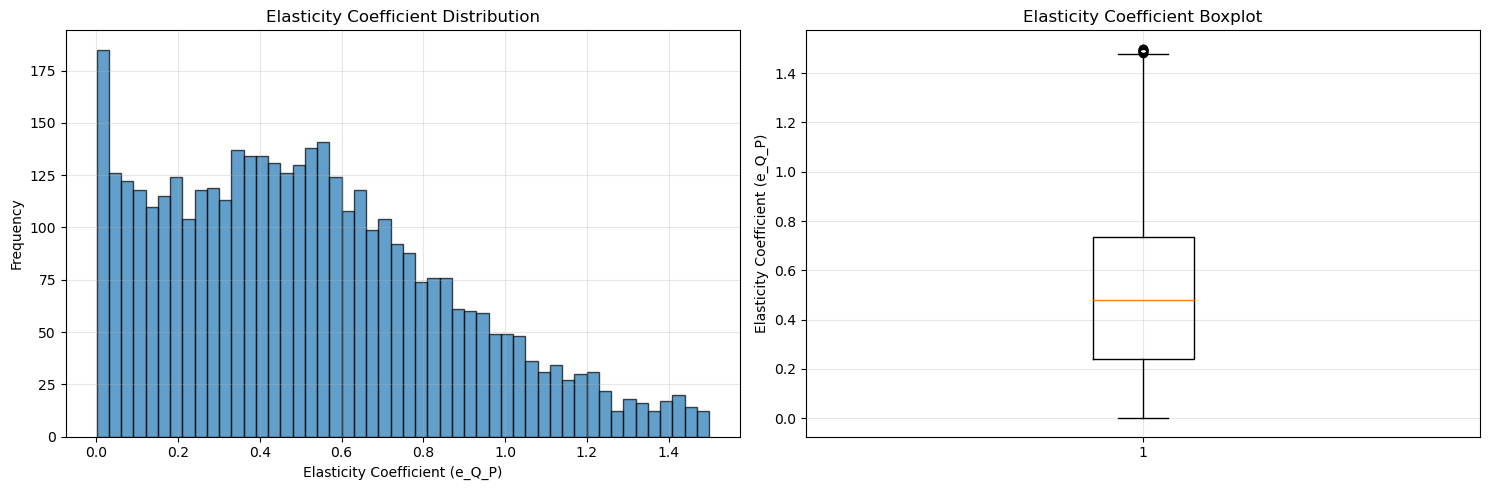

 Descriptive Statistics:
   Mean: 0.517
   Median: 0.481
   Std Dev: 0.344
   Min: 0.000
   Max: 1.499
   Skewness: 0.562

 Feature Ranking using LassoCV
 Lasso optimal alpha: 0.000233
 Non-zero features: 103 / 116


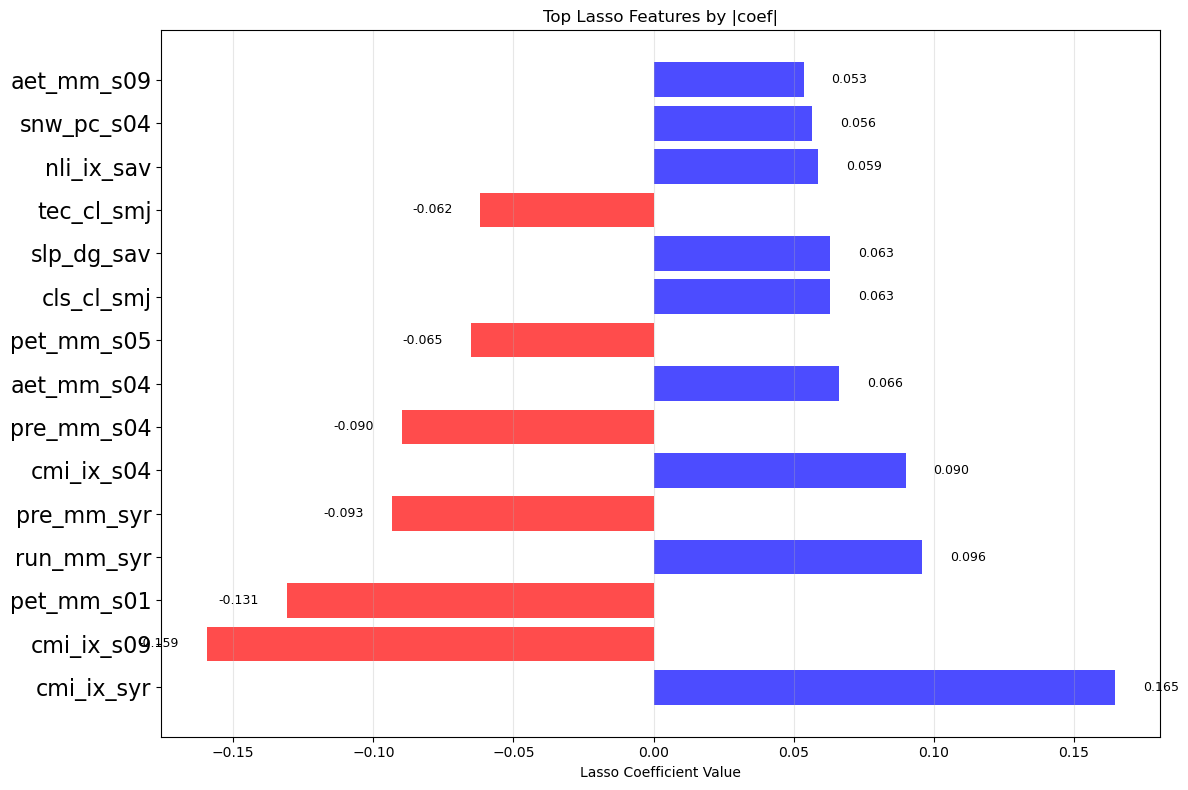


 Hyperparameter Optimization and Feature Selection

 Testing 10 features...
   CV R²: 0.5579
   Training R²: 0.7691
   Test R²: 0.5747
   Overfitting: 0.1944

 Testing 15 features...
   CV R²: 0.5815
   Training R²: 0.7840
   Test R²: 0.6053
   Overfitting: 0.1787

 Testing 20 features...
   CV R²: 0.5918
   Training R²: 0.7959
   Test R²: 0.6163
   Overfitting: 0.1796

 Testing 25 features...
   CV R²: 0.5915
   Training R²: 0.8044
   Test R²: 0.6142
   Overfitting: 0.1902

 Performance Comparison Across Different Feature Numbers:
   n_features   cv_r2  test_r2  overfitting
0          10  0.5579   0.5747       0.1944
1          15  0.5815   0.6053       0.1787
2          20  0.5918   0.6163       0.1796
3          25  0.5915   0.6142       0.1902

 Best Configuration:
   Number of features: 20
   Test R²: 0.6163
   Best hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


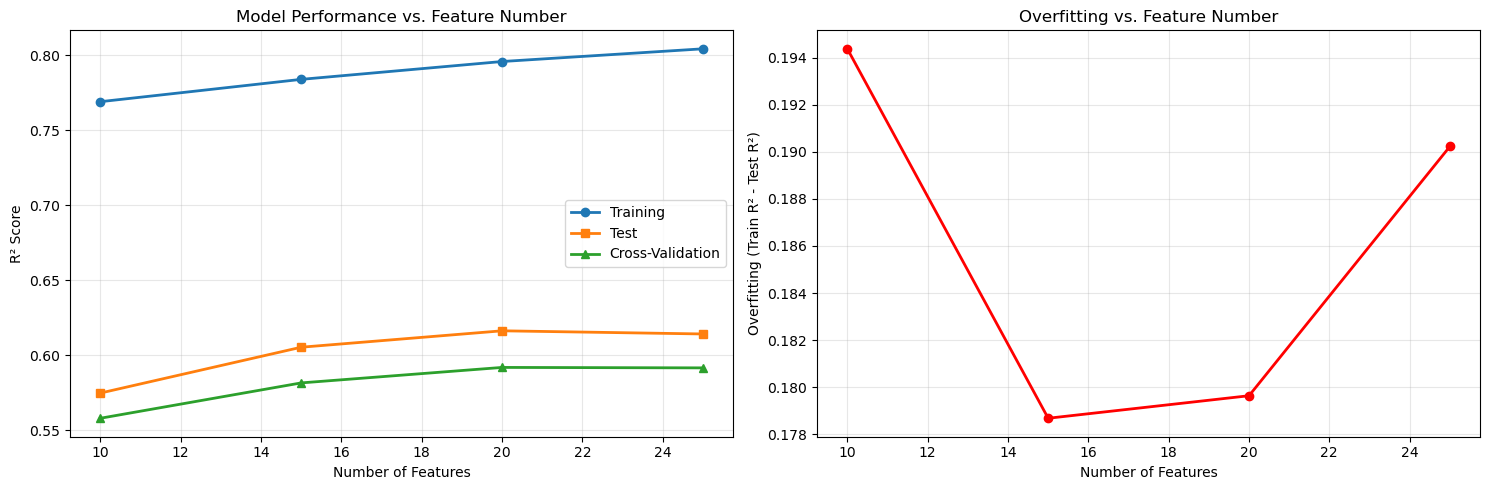


 Final Model Evaluation
 Model Performance Metrics:

Training:
   R²: 0.7959
   RMSE: 0.1557
   MAE: 0.1094

Test:
   R²: 0.6163
   RMSE: 0.2126
   MAE: 0.1535

10-fold Cross-Validation:
   Mean R²: 0.5931 ± 0.0424
   R² Range: [0.5340, 0.6556]


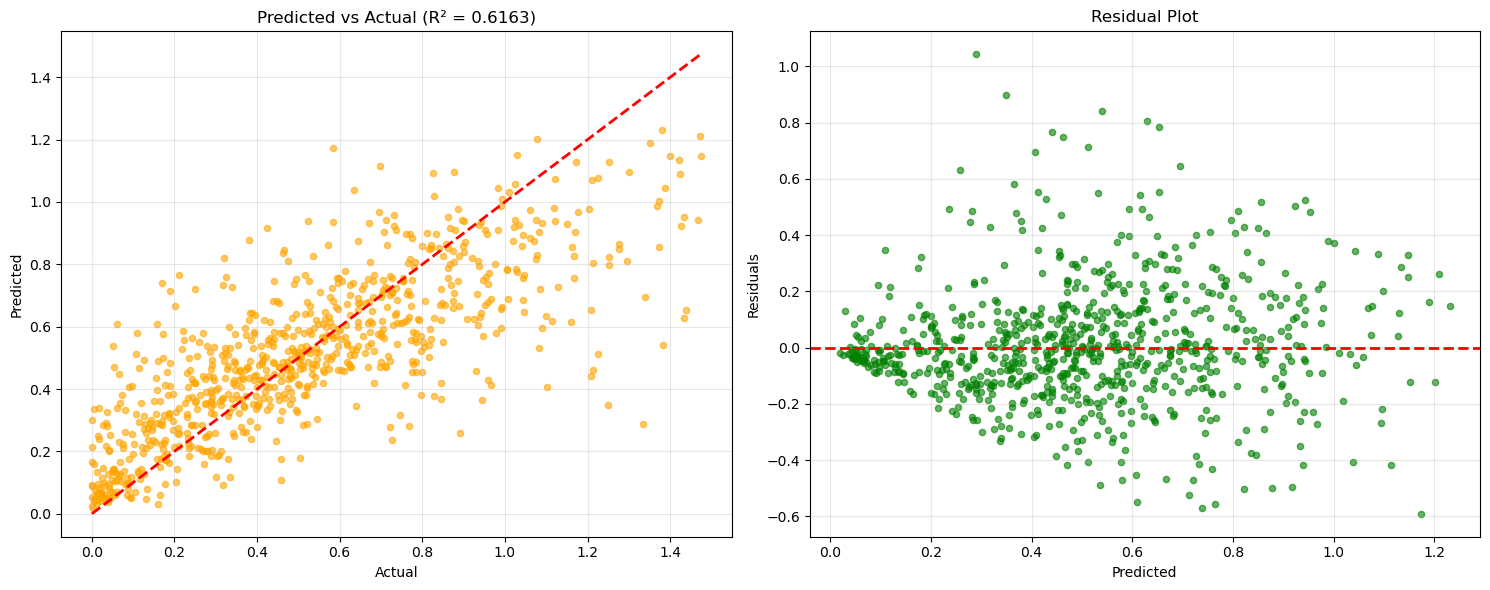


 In-depth analysis of feature importance
 Top 15 most important features:
    1. run_mm_syr               : RF=0.1577, Lasso=+0.0828
    2. cmi_ix_syr               : RF=0.1530, Lasso=+0.1070
    3. cmi_ix_s04               : RF=0.1175, Lasso=+0.0833
    4. soc_th_sav               : RF=0.0703, Lasso=+0.0396
    5. slp_dg_sav               : RF=0.0622, Lasso=+0.0726
    6. cmi_ix_s09               : RF=0.0585, Lasso=-0.0921
    7. pre_mm_syr               : RF=0.0467, Lasso=-0.0204
    8. pre_mm_s04               : RF=0.0356, Lasso=-0.0835
    9. aet_mm_s04               : RF=0.0302, Lasso=+0.0366
   10. snw_pc_s04               : RF=0.0295, Lasso=+0.0254
   11. crp_pc_sse               : RF=0.0286, Lasso=-0.0443
   12. aet_mm_s09               : RF=0.0286, Lasso=+0.0421
   13. pet_mm_s05               : RF=0.0279, Lasso=-0.0347
   14. aet_mm_syr               : RF=0.0251, Lasso=+0.0000
   15. ele_mt_sav               : RF=0.0247, Lasso=-0.0603


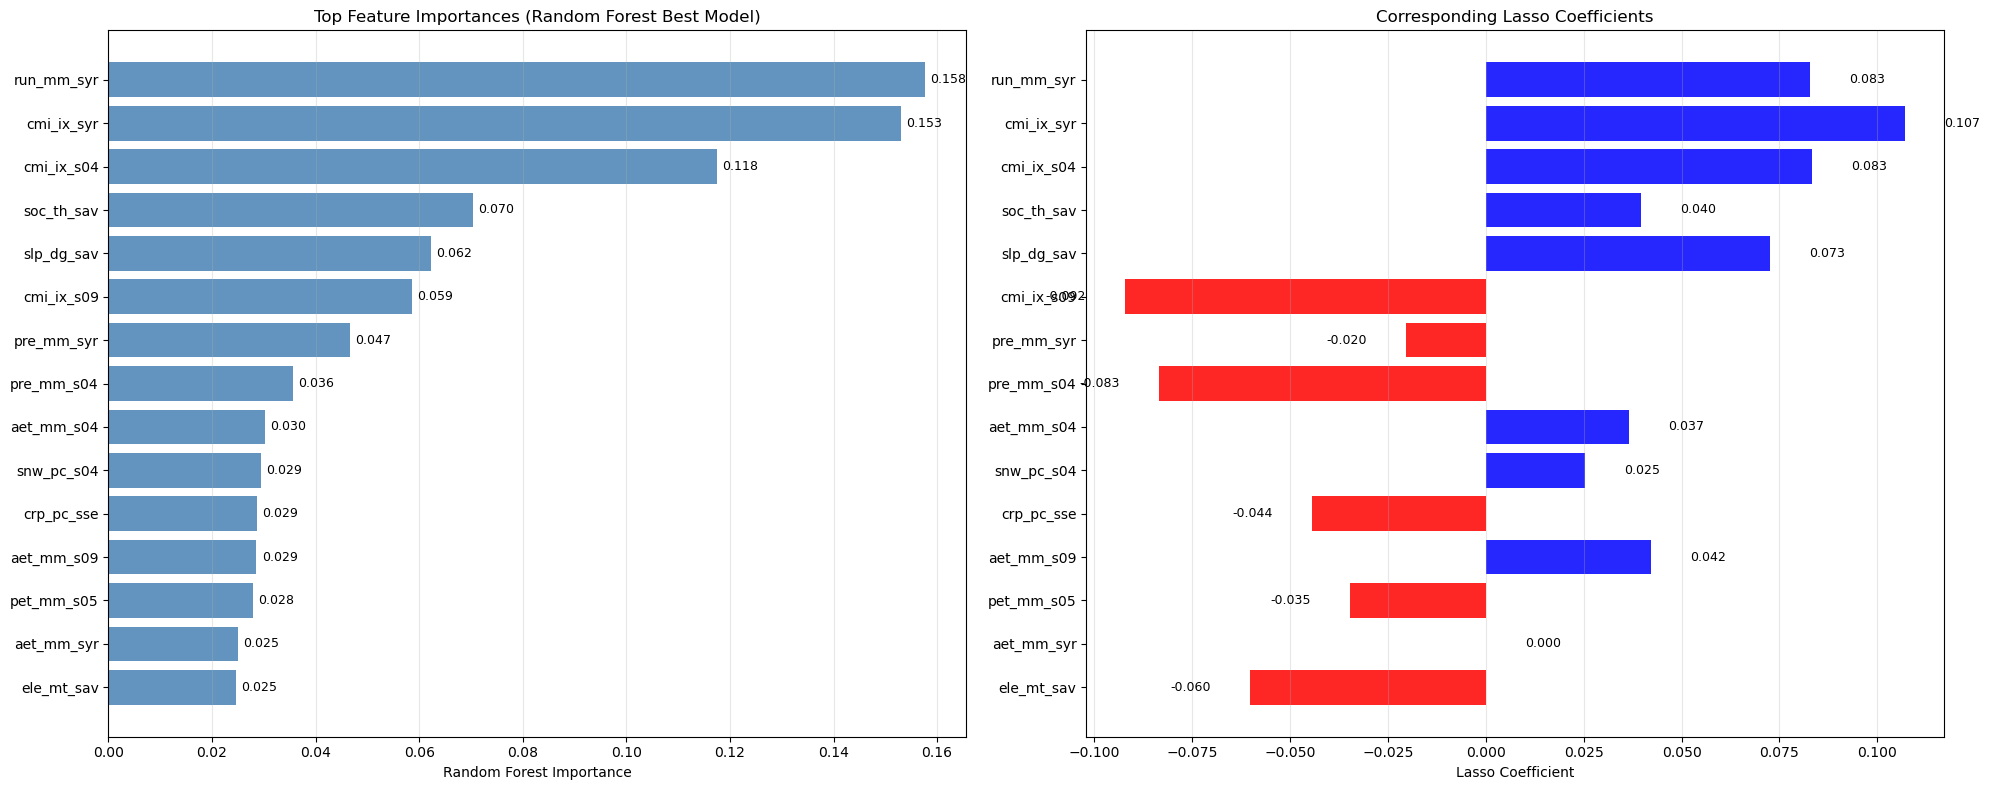

Physical Process Interpretation (Regex-based, leakage-safe)
Coverage audit (on FINAL selected features):
   Total selected features: 20
   Used after exclude_hydrology=True: 19
   Classified into known families: 16  (84.2%)
   Unclassified (need new rule or check naming): 3
   → Unclassified examples (top 3): ['tec_cl_smj', 'cls_cl_smj', 'fec_cl_smj']
   Note: *_cl_smj fields are categorical codes (majority class).
   For linear models you should one-hot encode; RF can ingest them as integers but interpretation
   is cleaner if one-hot expanded. Ensure your preprocessing reflects that in future runs.
Importance by physical process (cumulative, Random Forest):
   • Climate        : 0.4948
   • Topography     : 0.0869
   • Precipitation  : 0.0823
   • Soil_Properties: 0.0703
   • Unclassified   : 0.0585
   • Land_Cover     : 0.0286
   • Human_Impact   : 0.0208


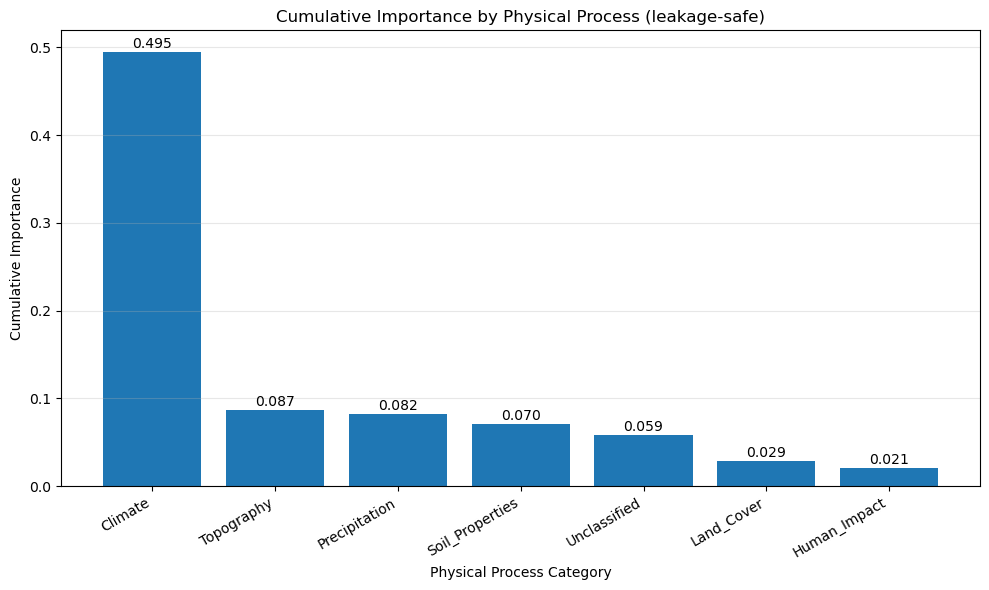

Top features by |importance| (after leakage-safe filtering):
   - cmi_ix_syr  →  Climate  (0.1530)
   - cmi_ix_s04  →  Climate  (0.1175)
   - soc_th_sav  →  Soil_Properties  (0.0703)
   - slp_dg_sav  →  Topography  (0.0622)
   - cmi_ix_s09  →  Climate  (0.0585)
   - pre_mm_syr  →  Precipitation  (0.0467)
   - pre_mm_s04  →  Precipitation  (0.0356)
   - aet_mm_s04  →  Climate  (0.0302)
   - snw_pc_s04  →  Climate  (0.0295)
   - crp_pc_sse  →  Land_Cover  (0.0286)

 Analysis completed!


 97%|=================== | 782/809 [00:21<00:00]       

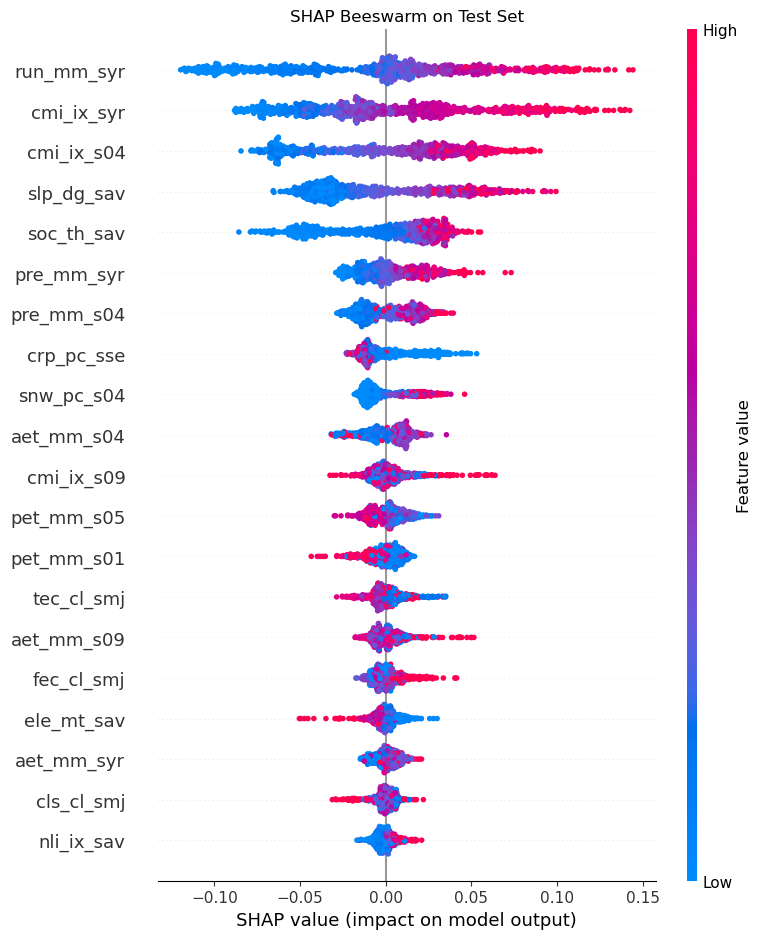


Analysis summary:
Optimal number of features: 20
Test set R²: 0.6163
The most important physical processes: ['Climate', 'Soil_Properties', 'Topography', 'Precipitation', 'Land_Cover']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
import warnings
import shap
warnings.filterwarnings('ignore')

class StreamflowElasticityAnalysis:
    def __init__(self, data_path):
        """
        Initialize Streamflow-Precipitation Elasticity Analysis
        """
        self.data_path = data_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.best_model = None
        self.selected_features = None            # final chosen features (top-k)
        self.lasso_ranked_features = None        # ranked by |coef| from lasso
        self.scaler = None                       # Standardizer for Lasso only
        self.best_n_features = None              # to mirror earlier output
        self.best_params = None

    def load_and_preprocess_data(self, low_threshold=0, upper_threshold=1.5):
        """
        Load and preprocess data
        """
        print("=" * 60)
        print(" Data Loading and Preprocessing")
        print("=" * 60)
        self.data = pd.read_csv(self.data_path)
        print(f" Original data shape: {self.data.shape}")

        # Clip y
        mask = (self.data.iloc[:, 1] >= low_threshold) & (self.data.iloc[:, 1] <= upper_threshold)
        self.data = self.data[mask]
        print(f" Shape after filtering: {self.data.shape}")

        self.y = self.data.iloc[:, 1]
        self.X = self.data.iloc[:, 2:]

        # Remove features with missing values
        missing_cols = self.X.isnull().sum()
        if missing_cols.sum() > 0:
            print(f" Missing values found: {missing_cols[missing_cols > 0].sum()}")
            self.X = self.X.dropna(axis=1)
            print(f" Number of features after removing missing values: {self.X.shape[1]}")

        self.X = self.remove_highly_correlated_features(self.X, threshold=0.9)
        self.X = self.remove_low_variance_features(self.X, threshold=1e-4)

        # Split data (stratified by quantiles of y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42,
            stratify=pd.qcut(self.y, q=5, duplicates='drop')
        )
        print(f" Training set: {self.X_train.shape}, Test set: {self.X_test.shape}")

    def explore_target_distribution(self):
        """
        Explore target variable distribution
        """
        print("\n" + "=" * 60)
        print(" Target Variable Distribution Analysis")
        print("=" * 60)

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].hist(self.y, bins=50, alpha=0.7, edgecolor='black')
        axes[0].set_title('Elasticity Coefficient Distribution')
        axes[0].set_xlabel('Elasticity Coefficient (e_Q_P)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)

        axes[1].boxplot(self.y)
        axes[1].set_title('Elasticity Coefficient Boxplot')
        axes[1].set_ylabel('Elasticity Coefficient (e_Q_P)')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f" Descriptive Statistics:")
        print(f"   Mean: {self.y.mean():.3f}")
        print(f"   Median: {self.y.median():.3f}")
        print(f"   Std Dev: {self.y.std():.3f}")
        print(f"   Min: {self.y.min():.3f}")
        print(f"   Max: {self.y.max():.3f}")
        print(f"   Skewness: {self.y.skew():.3f}")

    def remove_highly_correlated_features(self,X, threshold=0.9):
        import numpy as np
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        X_filtered = X.drop(columns=to_drop)
        print(f"Highly correlated feature de-duplication: {len(to_drop)} features removed, {X_filtered.shape[1]} features remaining")
        return X_filtered
    

    def remove_low_variance_features(self, X, threshold=1e-4):
        selector = VarianceThreshold(threshold=threshold)
        X_reduced = selector.fit_transform(X)
        kept_features = X.columns[selector.get_support(indices=True)]
        print(f"Low variance feature removal: {X.shape[1] - len(kept_features)} features removed, {len(kept_features)} features remaining")
        return pd.DataFrame(X_reduced, columns=kept_features)

    def lasso_feature_selection(self, alpha_range=None, cv=5, max_iter=5000):
        """
        Feature ranking using LassoCV (does NOT cut features yet).
        Stores features ranked by absolute coefficient magnitude in self.lasso_ranked_features.
        """
        print("\n" + "=" * 60)
        print(" Feature Ranking using LassoCV")
        print("=" * 60)

        # Standardize features for Lasso
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(self.X_train)

        # alpha search space
        if alpha_range is None:
            alpha_range = np.logspace(-4, 2, 50)

        lasso = LassoCV(alphas=alpha_range, cv=cv, random_state=42, max_iter=max_iter, selection='random')
        lasso.fit(X_train_scaled, self.y_train)

        coefs = lasso.coef_
        nonzero_mask = coefs != 0
        nonzero_features = self.X_train.columns[nonzero_mask]
        nonzero_coefs = coefs[nonzero_mask]

        # Rank by absolute coefficient
        order = np.argsort(np.abs(nonzero_coefs))[::-1]
        self.lasso_ranked_features = list(nonzero_features[order])

        print(f" Lasso optimal alpha: {lasso.alpha_:.6f}")
        print(f" Non-zero features: {nonzero_mask.sum()} / {self.X_train.shape[1]}")
        if len(self.lasso_ranked_features) == 0:
            print(" No features selected by Lasso! Will fallback to variance-based top features.")
            # Fallback: use top by variance
            variances = self.X_train.var().sort_values(ascending=False)
            self.lasso_ranked_features = list(variances.index[:50])

        # Quick coefficient plot (top 15 by |coef|)
        self._plot_lasso_coefficients(nonzero_features[order], nonzero_coefs[order])

        return self.lasso_ranked_features
    

    def _plot_lasso_coefficients(self, features, coefs, top_n=15):
        if len(features) == 0:
            return
        top_n = min(top_n, len(features))
        feats = np.array(features[:top_n])
        vals = np.array(coefs[:top_n])
        plt.figure(figsize=(12, 8))
        colors = ['red' if v < 0 else 'blue' for v in vals]
        bars = plt.barh(range(top_n), vals, alpha=0.7, color=colors)
        plt.yticks(range(top_n), feats, fontsize=16)
        plt.xlabel('Lasso Coefficient Value')
        plt.title('Top Lasso Features by |coef|')
        plt.grid(True, alpha=0.3, axis='x')
        for i, b in enumerate(bars):
            w = b.get_width()
            plt.text(w + (0.01 if w >= 0 else -0.01), b.get_y()+b.get_height()/2, f'{w:.3f}',
                     ha='left' if w >= 0 else 'right', va='center', fontsize=9)
        plt.tight_layout()
        plt.show()

    def optimize_hyperparameters(self, n_features_list=[10, 15, 20, 25]):
        """
        Hyperparameter optimization AND feature number selection (like the earlier code).
        Uses the ranked features from Lasso and searches over different top-k cutoffs.
        """
        print("\n" + "=" * 60)
        print(" Hyperparameter Optimization and Feature Selection")
        print("=" * 60)

        if not self.lasso_ranked_features:
            raise RuntimeError("Run lasso_feature_selection() first to get ranked features.")

        best_score = -np.inf
        best_params = {}
        best_n_features = 0
        results = []

        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [5, 10, 15],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [5, 10],
            'max_features': ['sqrt', 0.2]
        }

        for n_feat in n_features_list:
            print(f"\n Testing {n_feat} features...")
            current_feats = self.lasso_ranked_features[:min(n_feat, len(self.lasso_ranked_features))]
            X_train_sel = self.X_train[current_feats]
            X_test_sel = self.X_test[current_feats]

            rf = RandomForestRegressor(random_state=42, n_jobs=-1)
            grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=0)
            grid_search.fit(X_train_sel, self.y_train)

            train_score = grid_search.score(X_train_sel, self.y_train)
            test_score = grid_search.score(X_test_sel, self.y_test)
            cv_score = grid_search.best_score_

            results.append({
                'n_features': len(current_feats),
                'train_r2': train_score,
                'test_r2': test_score,
                'cv_r2': cv_score,
                'overfitting': train_score - test_score,
                'best_params': grid_search.best_params_
            })

            print(f"   CV R²: {cv_score:.4f}")
            print(f"   Training R²: {train_score:.4f}")
            print(f"   Test R²: {test_score:.4f}")
            print(f"   Overfitting: {train_score - test_score:.4f}")

            if test_score > best_score:
                best_score = test_score
                best_params = grid_search.best_params_
                best_n_features = len(current_feats)
                self.best_model = grid_search.best_estimator_
                self.selected_features = current_feats

        # Persist bests to mirror output structure
        self.best_n_features = best_n_features
        self.best_params = best_params

        # Show comparison plot/table
        results_df = pd.DataFrame(results)
        print("\n Performance Comparison Across Different Feature Numbers:")
        print(results_df[['n_features', 'cv_r2', 'test_r2', 'overfitting']].round(4))

        print(f"\n Best Configuration:")
        print(f"   Number of features: {best_n_features}")
        print(f"   Test R²: {best_score:.4f}")
        print(f"   Best hyperparameters: {best_params}")

        # Plots mirroring earlier code
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].plot(results_df['n_features'], results_df['train_r2'], 'o-', label='Training', linewidth=2)
        axes[0].plot(results_df['n_features'], results_df['test_r2'], 's-', label='Test', linewidth=2)
        axes[0].plot(results_df['n_features'], results_df['cv_r2'], '^-', label='Cross-Validation', linewidth=2)
        axes[0].set_xlabel('Number of Features')
        axes[0].set_ylabel('R² Score')
        axes[0].set_title('Model Performance vs. Feature Number')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(results_df['n_features'], results_df['overfitting'], 'ro-', linewidth=2)
        axes[1].set_xlabel('Number of Features')
        axes[1].set_ylabel('Overfitting (Train R² - Test R²)')
        axes[1].set_title('Overfitting vs. Feature Number')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return best_n_features, best_params

    def final_model_evaluation(self, best_n_features):
        """
        Final model evaluation (uses the previously chosen top-k selected_features)
        """
        print("\n" + "=" * 60)
        print(" Final Model Evaluation")
        print("=" * 60)

        # Ensure selected_features aligns with k
        feats = self.selected_features[:best_n_features]
        X_train_final = self.X_train[feats]
        X_test_final = self.X_test[feats]

        y_train_pred = self.best_model.predict(X_train_final)
        y_test_pred = self.best_model.predict(X_test_final)

        metrics = {
            'Training': {
                'R²': r2_score(self.y_train, y_train_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_train, y_train_pred)),
                'MAE': mean_absolute_error(self.y_train, y_train_pred)
            },
            'Test': {
                'R²': r2_score(self.y_test, y_test_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_test, y_test_pred)),
                'MAE': mean_absolute_error(self.y_test, y_test_pred)
            }
        }

        cv_scores = cross_val_score(self.best_model, X_train_final, self.y_train, cv=10, scoring='r2')
        print(" Model Performance Metrics:")
        for dataset, scores in metrics.items():
            print(f"\n{dataset}:")
            for metric, value in scores.items():
                print(f"   {metric}: {value:.4f}")
        print(f"\n10-fold Cross-Validation:")
        print(f"   Mean R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"   R² Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        axes[0].scatter(self.y_test, y_test_pred, alpha=0.6, s=20, color='orange')
        axes[0].plot([self.y_test.min(), self.y_test.max()],
                     [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title(f'Predicted vs Actual (R² = {metrics["Test"]["R²"]:.4f})')
        axes[0].grid(True, alpha=0.3)

        residuals = self.y_test - y_test_pred
        axes[1].scatter(y_test_pred, residuals, alpha=0.6, s=20, color='green')
        axes[1].axhline(0, color='r', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return metrics

    def analyze_feature_importance(self, best_n_features, top_n=15):
        """
        Analyze feature importance (Random Forest importances) and corresponding Lasso coefficients
        """
        print("\n" + "=" * 60)
        print(" In-depth analysis of feature importance")
        print("=" * 60)

        feats = self.selected_features[:best_n_features]
        feature_importance = self.best_model.feature_importances_
        
        # Get the corresponding Lasso coefficients
        lasso_coefs = []
        for f in feats:
            if f in self.X_train.columns:
                coef_idx = self.X_train.columns.get_loc(f)
                if hasattr(self, 'scaler') and self.scaler is not None:
                    # Get coefficients from the saved Lasso model
                    X_train_scaled = self.scaler.transform(self.X_train)
                    # Retrain Lasso to get coefficients (using the same parameters)
                    from sklearn.linear_model import Lasso
                    temp_lasso = Lasso(alpha=0.001, max_iter=5000)  # Use a smaller alpha to get more non-zero coefficients
                    temp_lasso.fit(X_train_scaled, self.y_train)
                    lasso_coefs.append(temp_lasso.coef_[coef_idx])
                else:
                    lasso_coefs.append(0.0)
            else:
                lasso_coefs.append(0.0)
        
        importance_df = pd.DataFrame({
            'feature': feats,
            'importance': feature_importance,
            'lasso_coef': lasso_coefs
        }).sort_values('importance', ascending=False)

        print(f" Top {top_n} most important features:")
        for i, (_, row) in enumerate(importance_df.head(top_n).iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:25s}: RF={row['importance']:.4f}, Lasso={row['lasso_coef']:+.4f}")

        # Biplot Visualisation: Random Forest Importance + Lasso Coefficient
        top_features = importance_df.head(top_n)
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Left: Importance of Random Forest
        axes[0].barh(range(len(top_features)), top_features['importance'], alpha=0.85, color='steelblue')
        axes[0].set_yticks(range(len(top_features)))
        axes[0].set_yticklabels(top_features['feature'])
        axes[0].invert_yaxis()
        axes[0].set_xlabel('Random Forest Importance')
        axes[0].set_title('Top Feature Importances (Random Forest Best Model)')
        axes[0].grid(True, axis='x', alpha=0.3)
        for i, (_, r) in enumerate(top_features.iterrows()):
            axes[0].text(r['importance'] + 0.001, i, f"{r['importance']:.3f}", va='center', fontsize=9)

        # Right: Corresponding Lasso coefficients
        colors = ['red' if c < 0 else 'blue' for c in top_features['lasso_coef']]
        axes[1].barh(range(len(top_features)), top_features['lasso_coef'], alpha=0.85, color=colors)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features['feature'])
        axes[1].invert_yaxis()
        axes[1].set_xlabel('Lasso Coefficient')
        axes[1].set_title('Corresponding Lasso Coefficients')
        axes[1].grid(True, axis='x', alpha=0.3)
        for i, (_, r) in enumerate(top_features.iterrows()):
            c = r['lasso_coef']
            axes[1].text(c + (0.01 if c >= 0 else -0.01), i, f"{c:.3f}",
                         ha='left' if c >= 0 else 'right', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

        return importance_df

    def physical_interpretation(self, importance_df, top_n=10, exclude_hydrology=True, show_uncovered_top=20):
        import re
        print("" + "=" * 60)
        print("Physical Process Interpretation (Regex-based, leakage-safe)")
        print("=" * 60)

        feats = importance_df['feature'].tolist()

        # Define regex mapping (project-specific)
        # NOTE: These rules follow Caravan/GRDC naming patterns.
        category_regex = {
            'Climate': [
                r'^cmi_', r'^ari_',               # climate/aridity indices
                r'^aet_mm_', r'^pet_mm_',         # ET/PET monthly/yearly
                r'^tmp_', r'^tmx_', r'^tmn_',     # temperature
                r'^snw_pc_',                      # snow fraction
            ],
            'Precipitation': [r'^pre_mm_'],
            'Soil_Water': [r'^swc_pc_'],
            'Topography': [r'^ele_', r'^slp_', r'^sgr_'],
            'Land_Cover': [
                r'^(for|crp|urb|gla|pac|pst)_pc_',
                r'^glc_pc_', r'^pnv_pc_', r'^wet_pc_'
            ],
            'Soil_Properties': [
                r'^(cly|slt|snd|soc)_', r'^lit_cl_', r'^kar_pc_', r'^ero_kh_'
            ],
            'Human_Impact': [
                r'^(gdp|hdi|pop|ppd|rdd|nli|hft)_'
            ],
            # Hydrology kept as a category but excluded by default via exclude_hydrology.
            'Hydrology': [r'^dis_m3_', r'^run_mm_', r'^riv_tc_', r'^rev_mc_', r'^lkv_mc_']
        }

        #  Helper to assign a category 
        def assign_category(name: str):
            for cat, patterns in category_regex.items():
                for pat in patterns:
                    if re.search(pat, name):
                        return cat
            return 'Unclassified'

        # Exclude hydrology features if requested (to avoid leakage)
        hydrology_pats = category_regex['Hydrology']
        def is_hydrology(name: str):
            return any(re.search(p, name) for p in hydrology_pats)

        mapped_rows = []
        for _, row in importance_df.iterrows():
            f = row['feature']
            imp = float(row['importance'])
            if exclude_hydrology and is_hydrology(f):
                continue
            cat = assign_category(f)
            mapped_rows.append((f, imp, cat))

        if not mapped_rows:
            print("  After excluding hydrology, nothing left to interpret. Consider setting exclude_hydrology=False.")
            return {}

        mapped_df = pd.DataFrame(mapped_rows, columns=['feature','importance','category'])

        #  Coverage Audit 
        total_selected = len(importance_df)
        used_after_exclude = mapped_df['feature'].nunique()
        n_unclassified = (mapped_df['category'] == 'Unclassified').sum()
        covered = used_after_exclude - n_unclassified
        coverage_pct = covered / used_after_exclude * 100 if used_after_exclude > 0 else 0.0

        print("Coverage audit (on FINAL selected features):")
        print(f"   Total selected features: {total_selected}")
        print(f"   Used after exclude_hydrology={exclude_hydrology}: {used_after_exclude}")
        print(f"   Classified into known families: {covered}  ({coverage_pct:.1f}%)")
        print(f"   Unclassified (need new rule or check naming): {n_unclassified}")

        if n_unclassified > 0:
            sample = mapped_df[mapped_df['category']=='Unclassified']['feature'].head(show_uncovered_top).tolist()
            print(f"   → Unclassified examples (top {min(show_uncovered_top, n_unclassified)}): {sample}")

        #  Categorical code fields note 
        cl_code_cols = [f for f in mapped_df['feature'] if f.endswith('_cl_smj')]
        if cl_code_cols:
            print("   Note: *_cl_smj fields are categorical codes (majority class).")
            print("   For linear models you should one-hot encode; RF can ingest them as integers but interpretation")
            print("   is cleaner if one-hot expanded. Ensure your preprocessing reflects that in future runs.")

        # Aggregate importances by category 
        agg = mapped_df.groupby('category', as_index=False)['importance'].sum()
        # Move Unclassified to the bottom
        agg = agg.sort_values(['category']).sort_values('importance', ascending=False)

        print("Importance by physical process (cumulative, Random Forest):")
        for _, r in agg.iterrows():
            print(f"   • {r['category']:<15s}: {r['importance']:.4f}")

        #  Plot 
        plt.figure(figsize=(10, 6))
        bars = plt.bar(agg['category'], agg['importance'])
        plt.xlabel('Physical Process Category')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Importance by Physical Process (leakage-safe)')
        plt.xticks(rotation=30, ha='right')
        for b, v in zip(bars, agg['importance']):
            plt.text(b.get_x()+b.get_width()/2, v + 0.001, f"{v:.3f}", ha='center', va='bottom')
        plt.tight_layout()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()

        #  Detailed listing of top_n features by category (text only) 
        top_feats = mapped_df.sort_values('importance', ascending=False).head(top_n)
        print("Top features by |importance| (after leakage-safe filtering):")
        for _, r in top_feats.iterrows():
            print(f"   - {r['feature']}  →  {r['category']}  ({r['importance']:.4f})")

        # Return dictionary {category: [features ...]} limited to top_n list membership
        categorized_features = {}
        for _, r in top_feats.iterrows():
            categorized_features.setdefault(r['category'], []).append(r['feature'])

        return categorized_features
    
    def shap_beeswarm(self, best_n_features, use_test=True, background_size=1000,
                  max_display=20, save_path=None):

        if self.best_model is None or self.selected_features is None:
            raise RuntimeError("Run optimize_hyperparameters() and final_model_evaluation() first.")

        feats = self.selected_features[:best_n_features]
        X_train_final = self.X_train[feats]
        X_test_final  = self.X_test[feats]

        X_eval = X_test_final if use_test else X_train_final

        if X_train_final.shape[0] > background_size:
            background = shap.sample(X_train_final, background_size, random_state=42)
        else:
            background = X_train_final

        explainer   = shap.Explainer(self.best_model, background)
        shap_values = explainer(X_eval)

        plt.figure(figsize=(10, 7))
        shap.plots.beeswarm(shap_values, max_display=max_display, show=False)
        plt.title("SHAP Beeswarm on Test Set" if use_test else "SHAP Beeswarm on Train Set")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

        return shap_values

    def run_complete_analysis(self, alpha_range=None):
        """
        Run the complete analysis pipeline (mirror previous output structure)
        Returns a dict with keys:
        'best_model', 'best_n_features', 'best_params', 'metrics', 'importance_df', 'categorized_features'
        """
        print("Start complete streamflow-precipitation elasticity analysis")
        print("=" * 80)

        # 1. Load & preprocess
        self.load_and_preprocess_data()

        # 2. Target distribution
        self.explore_target_distribution()

        # 3. Lasso ranking (no cut here)
        self.lasso_feature_selection(alpha_range)

        # 4. Hyperparameter optimization + choose feature count
        best_n_features, best_params = self.optimize_hyperparameters()

        # 5. Final evaluation using the chosen k
        metrics = self.final_model_evaluation(best_n_features)

        # 6. Analyze importances using chosen k
        importance_df = self.analyze_feature_importance(best_n_features)

        # 7. Physical interpretation
        categorized_features = self.physical_interpretation(importance_df)

        print("\n" + "=" * 80)
        print(" Analysis completed!")
        print("=" * 80)

        # 8. SHAP analysis
        shap_values = self.shap_beeswarm(
        best_n_features, use_test=True, background_size=1000,
        max_display=20, save_path="shap_beeswarm_test.png"
        )

        return {
            'best_model': self.best_model,
            'best_n_features': best_n_features,
            'best_params': best_params,
            'metrics': metrics,
            'importance_df': importance_df,
            'categorized_features': categorized_features,
            'shap_values': shap_values
        }

# Example usage
if __name__ == "__main__":
    analyzer = StreamflowElasticityAnalysis("final_eQP_prediction_dataset.csv")
    results = analyzer.run_complete_analysis()
    print("\nAnalysis summary:")
    print(f"Optimal number of features: {results['best_n_features']}")
    print(f"Test set R²: {results['metrics']['Test']['R²']:.4f}")
    print(f"The most important physical processes: {list(results['categorized_features'].keys())}")
